In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression, LogisticRegressionCV
from sklearn.base import BaseEstimator
from sklearn.linear_model import RidgeClassifier, RidgeCV
from sklearn import svm

### Набор данных с кристаллизацией

In [2]:
crys_df = pd.read_excel("lysozyme.xlsx")
crys_df = crys_df[["precipitater", "crystallization", "R", "dimer", "octamer"]]
crys_df.index = crys_df["precipitater"]
crys_df.drop("precipitater", axis=1, inplace=True)
crys_df.head()

,crystallization,R,dimer,octamer
precipitater,,,,
1_1,нет,14.3,0.0,0.0
1_10,нет,15.5,9.3,0.0
1_11,нет,15.0,5.4,0.0
1_13,нет,14.3,0.0,0.0
1_14,нет,14.3,0.0,0.0


### Спектры

In [3]:
# создаю словарь, где ключ - это id объекта, а значение - таблица с углами и интенсивностями
spectr_dir_root = "lysozyme_saxs/"
spectr_rows = 2578
skiprows = 3

spectr_df = {}
for file in os.listdir(spectr_dir_root):
    spec = pd.read_csv(os.path.join(spectr_dir_root, file), skiprows=skiprows, 
                       names=["scattering_angle", "intensity", "err"], 
                       nrows=spectr_rows, sep=" ", skipinitialspace=True)
    name_splitted = file.split("_")
    spectr_df[name_splitted[1][-1] + "_" + name_splitted[2]] = spec.drop("err", axis=1)

In [4]:
# Проверка на одинаковость углов (чтобы потом склеить все интенсивности)
template = np.array(spectr_df["1_1"]["scattering_angle"])
for obj_idx in spectr_df.keys():
    if np.any(template != np.array(spectr_df[obj_idx]["scattering_angle"])):
        print(obj_idx)

1_13
1_16
1_23
1_61
2_19


In [5]:
spectr_df["1_61"] # на одну запись меньше (другие также надо проверить)

,scattering_angle,intensity
0,1.496580e-01,1.666831e-02
1,1.524400e-01,1.643593e-02
2,1.552220e-01,1.652003e-02
3,1.580030e-01,1.690230e-02
4,1.607850e-01,1.644929e-02
...,...,...
2573,7.307080e+00,5.971450e-05
2574,7.309860e+00,-4.783830e-04
2575,7.312650e+00,6.471455e-04
2576,7.315430e+00,6.625720e-04


In [6]:
spectr_df["1_1"] # не хватает именно последнего значения для угла 7.318210. Удалим во всех таблицах

,scattering_angle,intensity
0,0.149658,0.016250
1,0.152440,0.015911
2,0.155222,0.015469
3,0.158003,0.016117
4,0.160785,0.015550
...,...,...
2573,7.307080,0.000300
2574,7.309860,-0.000509
2575,7.312650,0.000669
2576,7.315430,0.000504


In [7]:
# удаляем последнюю строку и переводим во float из object
for obj_idx in spectr_df.keys():
    spectr_df[obj_idx] = spectr_df[obj_idx].iloc[:-1].astype(float)

In [8]:
# Проверка на одинаковость углов
template = np.array(spectr_df["1_1"]["scattering_angle"])
for obj_idx in spectr_df.keys():
    if np.any(template != np.array(spectr_df[obj_idx]["scattering_angle"])):
        print(obj_idx)

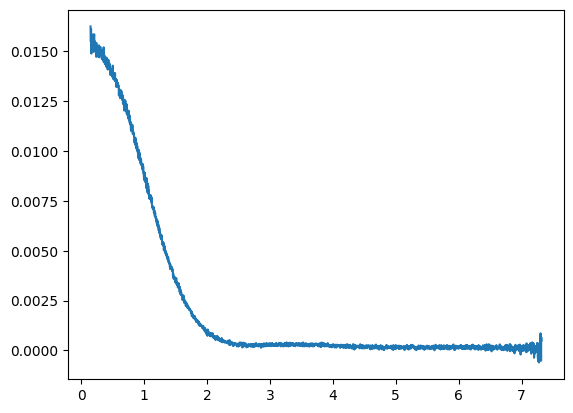

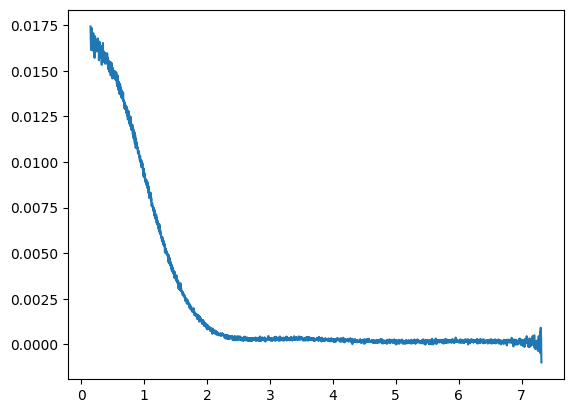

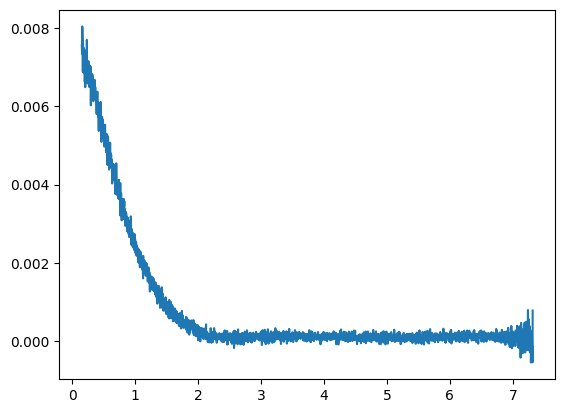

In [9]:
# построим графики для проверки. Похоже на спектр.
for i in ["1_1", "1_13", "2_19"]:
#     spectr_df[i]["intensity"].plot.bar(xticks=[])
    plt.plot(spectr_df[i]["scattering_angle"], spectr_df[i]["intensity"])
    plt.show()

In [10]:
intensity_lst = []
id_lst = []
intensty_arr = np.copy(spectr_df['1_1']["scattering_angle"].to_numpy())

for obj_idx in spectr_df.keys():
    spectr_df[obj_idx].drop("scattering_angle", axis=1, inplace=True) # удаляю угол
    intensity_lst.append(spectr_df[obj_idx].T) # запихиваю все интенсивности в один список
    id_lst.append(obj_idx)

In [11]:
# склеиваю все интенсивности для каждого объекта в одну таблицу. Индексом ставим id кристалла
intensity_df = pd.concat(intensity_lst)
intensity_df.index = id_lst
intensity_df.head()

,0,1,2,3,4,5,6,7,8,9,...,2567,2568,2569,2570,2571,2572,2573,2574,2575,2576
1_10,0.015204,0.015595,0.014513,0.015322,0.015911,0.016054,0.016275,0.016414,0.016364,0.016525,...,0.000354,-0.000526,0.000580,0.000166,0.000465,-0.000197,0.001208,-0.000295,-0.001411,-0.000061
1_11,0.019323,0.019261,0.019730,0.019324,0.018704,0.019049,0.019382,0.019100,0.018756,0.018227,...,-0.000352,-0.000044,-0.000442,-0.000224,-0.000141,-0.000200,0.000938,0.000285,-0.000714,0.000793
1_13,0.017424,0.017039,0.016708,0.016138,0.016734,0.017310,0.016568,0.017152,0.017331,0.016165,...,0.000347,0.000196,0.000694,-0.000483,-0.000056,0.000911,0.000445,0.000475,-0.000155,-0.000995
1_14,0.012603,0.012585,0.012807,0.012688,0.012501,0.012358,0.012127,0.012399,0.012862,0.012107,...,-0.000454,0.000445,-0.000407,0.000350,-0.000147,-0.000461,-0.000753,0.000183,-0.000301,-0.000997
1_15,0.015187,0.015511,0.015361,0.015478,0.015671,0.015139,0.015380,0.015419,0.015293,0.015504,...,-0.000285,-0.000243,0.000146,0.000221,-0.000565,-0.000096,-0.000321,0.000688,0.000112,-0.000591


In [12]:
df = intensity_df.join(crys_df) # собрали датасет воедино

In [13]:
df.shape

(56, 2581)

In [14]:
df

,0,1,2,3,4,5,6,7,8,9,...,2571,2572,2573,2574,2575,2576,crystallization,R,dimer,octamer
1_10,0.015204,0.015595,0.014513,0.015322,0.015911,0.016054,0.016275,0.016414,0.016364,0.016525,...,0.000465,-0.000197,0.001208,-0.000295,-0.001411,-0.000061,нет,15.5,9.3,0.0
1_11,0.019323,0.019261,0.019730,0.019324,0.018704,0.019049,0.019382,0.019100,0.018756,0.018227,...,-0.000141,-0.000200,0.000938,0.000285,-0.000714,0.000793,нет,15.0,5.4,0.0
1_13,0.017424,0.017039,0.016708,0.016138,0.016734,0.017310,0.016568,0.017152,0.017331,0.016165,...,-0.000056,0.000911,0.000445,0.000475,-0.000155,-0.000995,нет,14.3,0.0,0.0
1_14,0.012603,0.012585,0.012807,0.012688,0.012501,0.012358,0.012127,0.012399,0.012862,0.012107,...,-0.000147,-0.000461,-0.000753,0.000183,-0.000301,-0.000997,нет,14.3,0.0,0.0
1_15,0.015187,0.015511,0.015361,0.015478,0.015671,0.015139,0.015380,0.015419,0.015293,0.015504,...,-0.000565,-0.000096,-0.000321,0.000688,0.000112,-0.000591,нет,14.3,0.0,0.0
1_16,0.016613,0.016342,0.016100,0.016849,0.016388,0.016375,0.015699,0.016309,0.016204,0.016243,...,0.000737,0.000035,0.000257,-0.000471,0.000616,0.001034,нет,14.5,1.7,0.0
1_17,0.014560,0.014204,0.013854,0.013830,0.014655,0.013905,0.014425,0.013696,0.013796,0.013681,...,-0.000961,-0.000372,0.000062,0.000867,-0.002361,-0.001055,нет,16.3,18.4,0.0
1_18,0.014603,0.015646,0.015562,0.014946,0.015192,0.015477,0.015546,0.015472,0.015267,0.015261,...,0.000133,0.000978,-0.000530,0.000663,0.000736,0.000674,нет,14.3,0.0,0.0
1_1,0.016250,0.015911,0.015469,0.016117,0.015550,0.014891,0.015256,0.015498,0.015291,0.015053,...,0.000858,-0.000237,0.000300,-0.000509,0.000669,0.000504,нет,14.3,0.0,0.0
1_20,0.019304,0.019266,0.018843,0.019077,0.019051,0.018925,0.019914,0.019187,0.019442,0.018299,...,-0.000344,0.000605,0.000429,0.000839,0.001052,-0.000523,нет,17.1,25.9,0.1


# Обучение (Классификация)

In [15]:
from sklearn.model_selection import LeaveOneOut

In [16]:
# кодируем отклик
le = LabelEncoder()
le.fit(df["crystallization"])
df["crystallization"] = le.transform(df["crystallization"])

In [17]:
# разделяем отклик и признаки
X = df.drop(["crystallization", "dimer", "octamer", "R"], axis=1)
y = df["crystallization"]

Модели которые нужно попробовать:
* ExtraTrees
* SVC
* Logistic
* MLP

In [18]:
# скалирование (чтобы всё было +- в одном диапазоне)
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [19]:
# Метод снижения размерности
pca = PCA(n_components=50)
pca.fit(X)
pca.explained_variance_ratio_

array([7.70880544e-01, 1.83830413e-01, 1.03799226e-02, 9.33711004e-03,
       2.09390520e-03, 1.25567957e-03, 1.13137075e-03, 9.24118146e-04,
       8.61635995e-04, 8.39567527e-04, 7.96347594e-04, 7.69295040e-04,
       7.09892779e-04, 6.80615121e-04, 6.67870556e-04, 6.22933501e-04,
       6.13012734e-04, 5.81938756e-04, 5.62624286e-04, 5.52819439e-04,
       5.16048751e-04, 4.99438190e-04, 4.89498248e-04, 4.81529911e-04,
       4.74785459e-04, 4.54998591e-04, 4.42134513e-04, 4.31952680e-04,
       4.17316657e-04, 4.04107318e-04, 3.98003412e-04, 3.85930772e-04,
       3.75216946e-04, 3.52903869e-04, 3.42641983e-04, 3.42219898e-04,
       3.29647137e-04, 3.20641754e-04, 3.15997882e-04, 3.05273391e-04,
       2.99691014e-04, 2.94051537e-04, 2.87633988e-04, 2.78656403e-04,
       2.70643831e-04, 2.65819984e-04, 2.60895834e-04, 2.54683354e-04,
       2.44632725e-04, 2.43462150e-04])

In [20]:
# Применение PCA
pca = PCA(n_components=3, random_state=123)
X_pca = pca.fit_transform(X)

**Комментарий:** PCA поместить в отдельный раздел в конце, не смешивая его с основным кодом по заданию.

## Первая модель

In [21]:
from sklearn.ensemble import ExtraTreesClassifier

In [22]:
clf = ExtraTreesClassifier(random_state=123)
y_pred = cross_val_predict(clf, X_pca, y, cv=LeaveOneOut())
print("accuracy:", accuracy_score(y, y_pred))

accuracy: 0.6071428571428571


**Комментарий:** Пока что я бы хотел увидеть качество предсказания на исходном X. PCA предлагаю оставить на следующую итерацию. Плюс к тому - везде нужно использовать LOOCV. 

## Вторая модель

In [23]:
clf = svm.SVC(C=1, kernel="rbf")
cvs = cross_val_score(clf, X_pca, y, cv=LeaveOneOut(), scoring="accuracy")
print("accuracy:", cvs.mean())

accuracy: 0.6428571428571429


## Третья модель

In [24]:
clf = LogisticRegression(C=3, multi_class="ovr")
cvs = cross_val_score(clf, X_pca, y, cv=LeaveOneOut(), scoring="accuracy")
print("accuracy:", cvs.mean())

C:\Users\ПОЛЬЗОВАТЕЛЬ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\ПОЛЬЗОВАТЕЛЬ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\ПОЛЬЗОВАТЕЛЬ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn

accuracy: 0.7678571428571429


C:\Users\ПОЛЬЗОВАТЕЛЬ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


**Комментарий:** Вместо LogisticRegression лучше использовать LogisticRegressionCV. Параметров задавать не нужно кроме, разве что, random_state.

## дополнительные действия

## Четвертая модель

In [26]:
# Второй вариант

# без использования коррелирующих данных
clf = MLPClassifier((100, 10), max_iter=1000, random_state=123)
cvs = cross_val_score(clf, X_pca, y, cv=LeaveOneOut(), scoring="accuracy")
print("accuracy:", cvs.mean())

C:\Users\ПОЛЬЗОВАТЕЛЬ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ПОЛЬЗОВАТЕЛЬ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ПОЛЬЗОВАТЕЛЬ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ПОЛЬЗОВАТЕЛЬ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterat

accuracy: 0.5892857142857143


C:\Users\ПОЛЬЗОВАТЕЛЬ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


### обучила дополнительно

In [27]:
# другие модели
clf = KNeighborsClassifier()
cvs = cross_val_score(clf, X_pca, y, cv=LeaveOneOut(), scoring="accuracy")
print("accuracy:", cvs.mean())

accuracy: 0.6785714285714286


**Комментарий:**  
  
Задание 1:  
Визуализировать предсказание лучшей модели с помощью confusion matrix (есть в sklearn)  
  
Задание 2:  
2.1 Отобрать (любым подходящим методом) два лучших признака  
2.2 Обучить на них одну линейную и одну нелинейную модели  
2.3 Постороить тепловые карты предсказания, используя обученные модели (код есть в одном из ноутбуков). Нанести на нее точки исходной выборки, истинный класс каждой точки обозначить цветом.  

**Задание 1**

In [28]:
best_model = LogisticRegressionCV()

In [29]:
v_predict = cross_val_predict(best_model, X_pca, y, cv=LeaveOneOut())

C:\Users\ПОЛЬЗОВАТЕЛЬ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ПОЛЬЗОВАТЕЛЬ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

**Комментарий:** с 2000ми признаков действительно обучается очень долго. Предлагаю совместно разобраться с этим пунктом на следующей итерации.

In [30]:
accuracy_score(y, v_predict)

0.6964285714285714

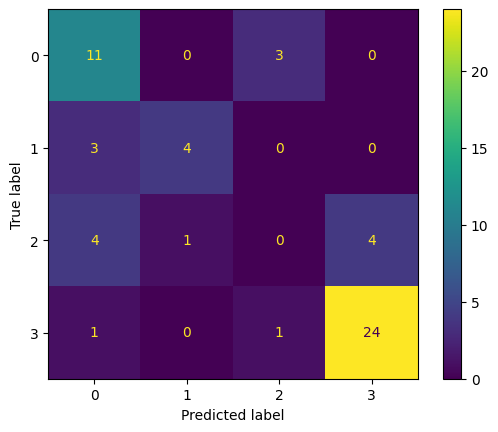

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

y_true = y # тут вектор разметки
y_pred = v_predict # тут вектор предсказания
cm = confusion_matrix(y_true, y_pred,)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

**Задание 2**

In [32]:
from sklearn.feature_selection import f_classif
scors = f_classif(X, y)
scors

(array([2.58587795, 2.85221615, 3.32096891, ..., 3.0103935 , 1.34126865,
        1.53798818]),
 array([0.06295601, 0.04609351, 0.02673611, ..., 0.03833047, 0.27107393,
        0.21566064]))

In [33]:
#2.1
scors = scors[0]
scors 

array([2.58587795, 2.85221615, 3.32096891, ..., 3.0103935 , 1.34126865,
       1.53798818])

In [34]:
X_best = X[:, np.argsort(scors)[::-1]][:, :2]
X_best   #ТУТ ПОЛУЧИЛИСЬ ДРУГИЕ ЗНАЧЕНИЯ, ЭТ НОРМИК?

array([[ 0.76425066,  0.56070353],
       [ 1.34126964,  1.33026067],
       [ 1.39360258,  1.40647519],
       [ 0.87711989,  0.83835829],
       [ 1.13942676,  0.98950382],
       [ 0.99144139,  0.93822074],
       [ 0.03726459,  0.0283388 ],
       [ 0.6382174 ,  0.77105705],
       [ 1.24053319,  1.14604883],
       [ 0.59932917,  0.71983141],
       [ 1.029932  ,  1.00375914],
       [-0.57803024, -0.66295574],
       [ 1.35471648,  1.377612  ],
       [ 1.70685604,  1.74284671],
       [ 1.00615976,  1.01522558],
       [-0.52189118, -0.48085338],
       [ 0.63346296,  0.60373291],
       [-0.85161807, -0.81151444],
       [ 1.08448907,  1.12608307],
       [-1.01289038, -0.92924546],
       [-0.82116452, -0.86977365],
       [-0.72066324, -0.68601738],
       [-0.72947087, -0.67965527],
       [-1.2524197 , -1.46577924],
       [ 0.97341871,  0.83461273],
       [-0.48484434, -0.57581353],
       [ 0.19404016,  0.22102816],
       [ 0.79168655,  0.81798846],
       [-0.35780321,

In [35]:
#2.2.1 (ОБУЧЕНИЕ ЛИНЕЙНОЙ МОДЕЛИ НА ЛУЧШИХ ПРИЗНАКАХ)
clf = LogisticRegressionCV()
cvs = cross_val_score(clf, X_best, y, cv=LeaveOneOut(), scoring="accuracy")
print("accuracy:", cvs.mean())

accuracy: 0.7321428571428571


In [36]:
#2.2.2 (ОБУЧЕНИЕ НЕЛИНЕЙНОЙ МОДЕЛИ НА ЛУЧШИХ ПРИЗНАКАХ)
clf = MLPClassifier((100, 10), max_iter=2000, random_state=123)
cvs = cross_val_score(clf, X_best, y, cv=LeaveOneOut(), scoring="accuracy")
print("accuracy:", cvs.mean())

C:\Users\ПОЛЬЗОВАТЕЛЬ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ПОЛЬЗОВАТЕЛЬ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ПОЛЬЗОВАТЕЛЬ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ПОЛЬЗОВАТЕЛЬ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterat

accuracy: 0.6428571428571429


C:\Users\ПОЛЬЗОВАТЕЛЬ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


(-2.136820812641243, 1.7428467051790846)

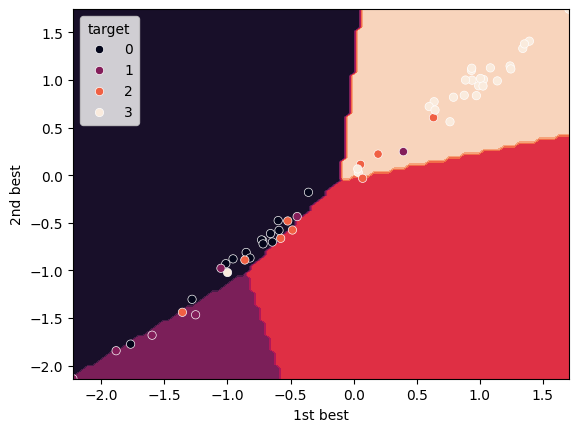

In [56]:
#2.3

fig, ax = plt.subplots()
best_model.fit(X_best, y)

xlim = (X_best[:, 0].min(), X_best[:, 0].max())
ylim = (X_best[:, 1].min(), X_best[:, 1].max())
grid_x = np.linspace(*xlim, 100)
grid_y = np.linspace(*ylim, 100)
xx, yy = np.meshgrid(grid_x, grid_y)
grid = np.c_[xx.ravel(), yy.ravel()]
prediction = best_model.predict(grid).reshape(xx.shape)
ax.contourf(xx, yy, prediction, cmap=sns.color_palette("rocket", as_cmap=True))

ax = sns.scatterplot(data=pd.DataFrame(data={'1st best': X_best[:, 0], '2nd best': X_best[:, 1], 'target': y}),
                     x='1st best', y='2nd best', hue='target', palette="rocket", ax=ax)
ax.set_xlim(*xlim)
ax.set_ylim(*ylim)

**Комментарий:** Такую же карту для нелинейного метода.  
**Advanced:** Реализовать функцию постороения тепловой карты предсказания. На вход функция принимает model, X, y.

In [37]:
def viz(best_model, X_best, y):
    fig, ax = plt.subplots()
    best_model.fit(X_best, y)
    xlim = (X_best[:, 0].min(), X_best[:, 0].max())
    ylim = (X_best[:, 1].min(), X_best[:, 1].max())
    
    grid_x = np.linspace(*xlim, 100)
    grid_y = np.linspace(*ylim, 100)
    xx, yy = np.meshgrid(grid_x, grid_y)
    grid = np.c_[xx.ravel(), yy.ravel()]
    prediction = best_model.predict(grid).reshape(xx.shape)
    
    ax.contourf(xx, yy, prediction, cmap=sns.color_palette("rocket", as_cmap=True))


    sns.scatterplot(data=pd.DataFrame(data={'1st best': X_best[:, 0], '2nd best': X_best[:, 1], 'target': y}),
                    x='1st best', y='2nd best', hue='target', palette="rocket", ax=ax)
    
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    plt.title('Визуализация модели')
    plt.show()


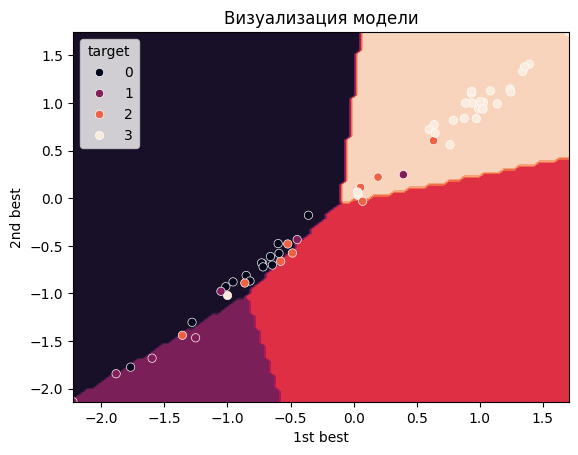

In [38]:
viz(best_model, X_best, y)

# Обучение (Регрессия)

In [93]:
# предсказываю R
y = df["R"]

**Комментарий:**

Модели которые нужно попробовать:
* ExtraTrees
* SVR
* Ridge
* MLP

Для оценки качества также использовать R<sup>2</sup>-score

### Первая модель

In [94]:
rg = ExtraTreesRegressor()
ypred = cross_val_predict(rg, X_pca, y, cv=LeaveOneOut())
r2_score(df["R"], ypred)

0.7660133734433965

### Вторая модель

In [95]:
from sklearn.svm import SVR

In [96]:
rg = SVR()
ypred = cross_val_predict(rg, X_pca, y, cv=LeaveOneOut())
r2_score(df["R"], ypred)

0.6467189214796751

### Третья модель

In [97]:
rg = RidgeCV()
ypred = cross_val_predict(rg, X_pca, y, cv=LeaveOneOut())
r2_score(df["R"], ypred)

-0.38669751690053955

### Четвертая модель

In [98]:
rg = MLPRegressor((30, 40, 10), max_iter=1000, random_state=123)
ypred1 = cross_val_predict(rg, X_pca, y, cv=LeaveOneOut())
r2_score(y, ypred1)

C:\Users\ПОЛЬЗОВАТЕЛЬ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ПОЛЬЗОВАТЕЛЬ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ПОЛЬЗОВАТЕЛЬ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ПОЛЬЗОВАТЕЛЬ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterat

-16.708613219797016

**Комментарий:**  
  
Задание 1:  
Визуализировать предсказание лучшей модели с помощью true-preddicted scatterplot (используя, например, библиотеку seaborn)  
  
Задание 2:  
2.1 Отобрать (любым подходящим методом) два лучших признака  
2.2 Обучить на них одну линейную и одну нелинейную модели  
2.3 Постороить тепловые карты предсказания, используя обученные модели (код есть в одном из ноутбуков). Нанести на нее точки исходной выборки, истинное значение таргета в каждой точке обозначить цветом.  

### Задание 1

In [99]:
best_model1 = ExtraTreesRegressor()

In [100]:
ypred1 = cross_val_predict(best_model1, X_pca, y, cv=LeaveOneOut())

In [101]:
import matplotlib.pyplot as plt
import seaborn as sns

In [102]:

def truePredicted(Y_test, Y_pred, target):
    sns.set(rc={'figure.dpi':300})
    low, high = np.min(np.minimum(Y_test, Y_pred)), np.max(np.maximum(Y_test, Y_pred))
    ax = sns.scatterplot(x=Y_test, y=Y_pred)
    sns.lineplot(x=[low, high], y=[low, high], ax=ax)
    ax.set_ylabel(f'Predicted {target}')


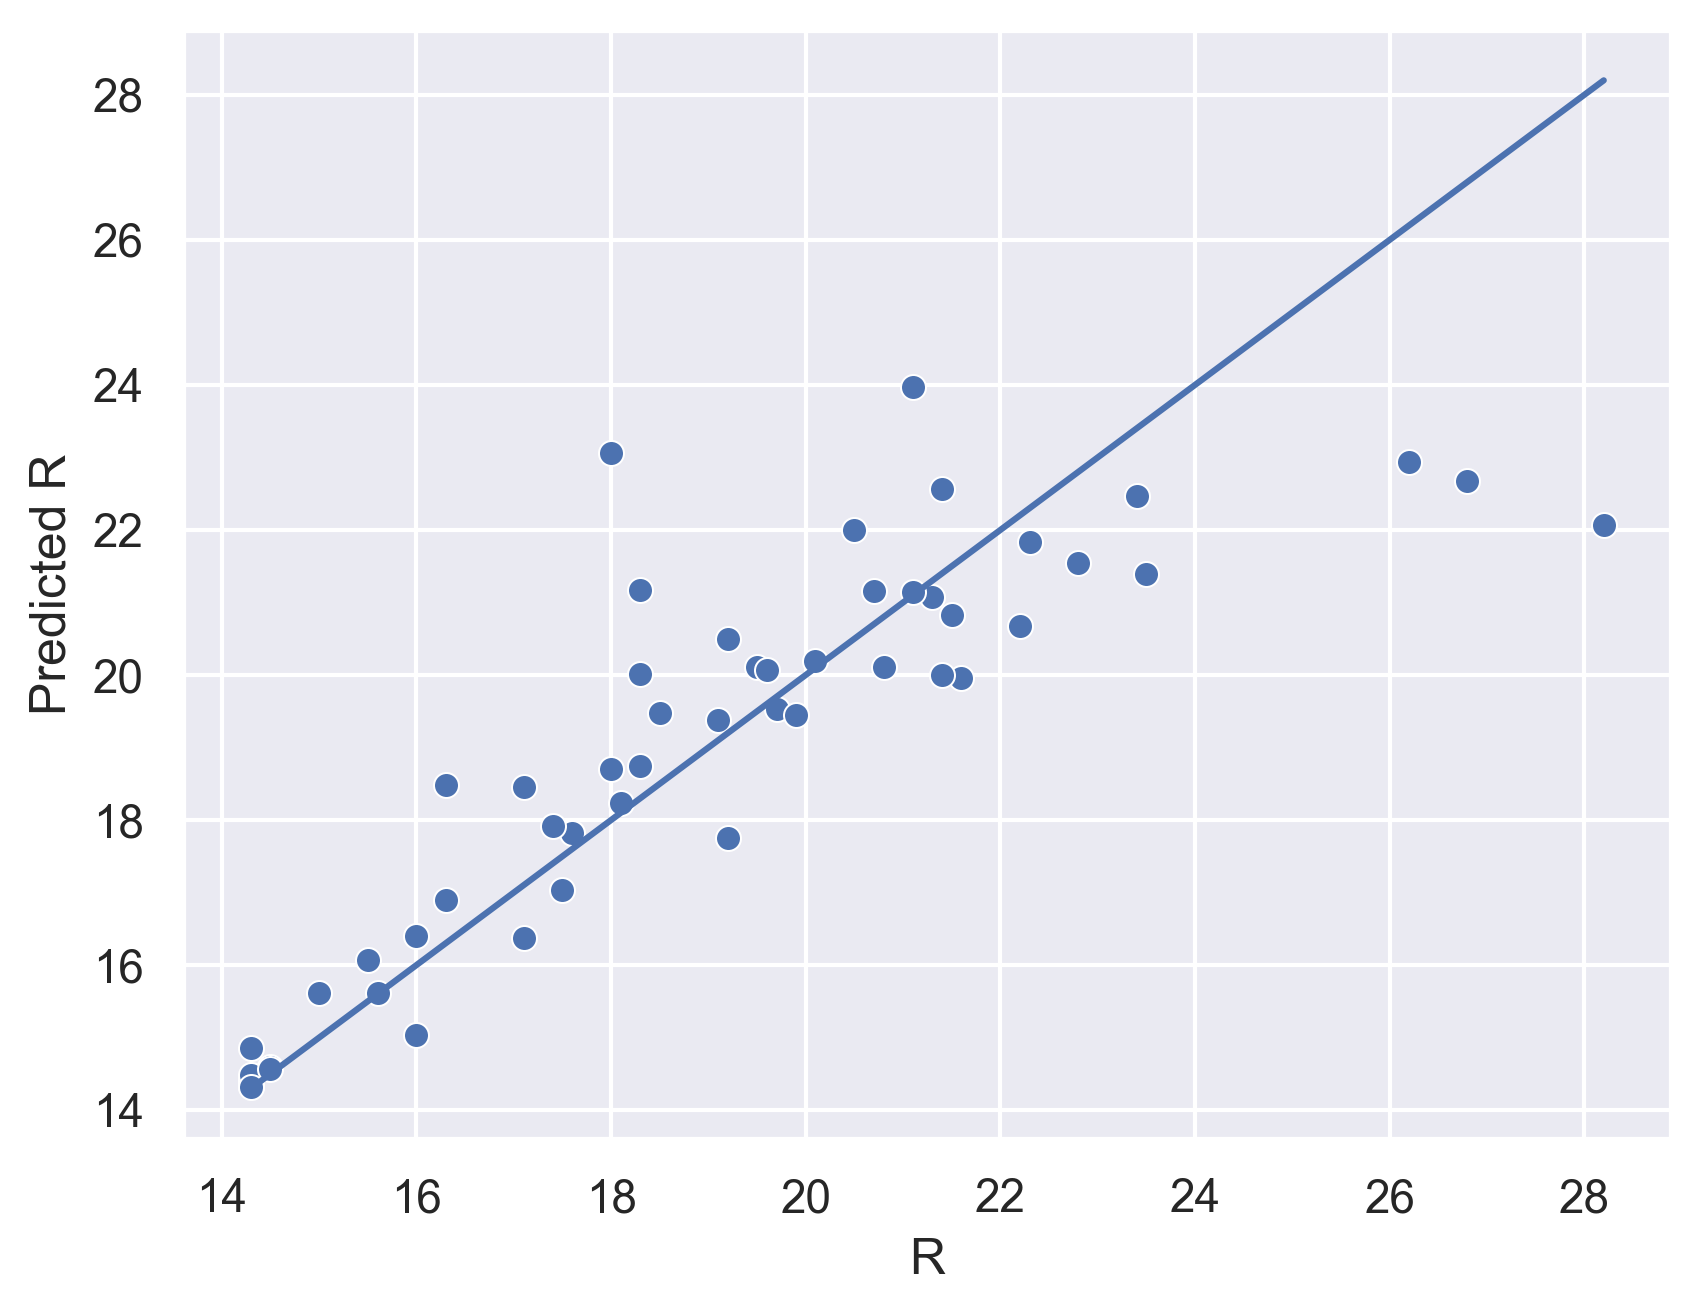

In [104]:
truePredicted(y, ypred1, "R")

In [105]:
#sns.scatterplot(x=y, y=ypred1)
#y_true - реальные метки
#y_pred - предсказания

### Задание 2

In [106]:
#2.1
rg = ExtraTreesRegressor()
rg.fit(X, y)
a = rg.feature_importances_
X_best1 = X[:, np.argsort(a)[::-1]][:, :2]
X_best1

array([[ 0.69660919,  0.70591908],
       [ 1.20996353,  1.26397278],
       [ 1.37791664,  1.33066505],
       [ 0.76932464,  0.70512341],
       [ 1.14753876,  1.08157477],
       [ 0.91852827,  0.93762127],
       [ 0.09516089,  0.15599775],
       [ 0.88552888,  0.8266501 ],
       [ 1.06981566,  1.26201678],
       [ 0.47896046,  0.44703619],
       [ 1.08687879,  0.86527441],
       [-1.0296431 , -0.88229557],
       [ 1.26390423,  1.35475294],
       [ 1.12489106,  1.15922418],
       [ 0.72771046,  0.93092735],
       [-0.49048186, -0.72902249],
       [ 0.48840144,  0.48118557],
       [-0.68972623, -0.59628324],
       [ 0.82635917,  0.96282412],
       [-0.8170116 , -0.66446015],
       [-0.9301377 , -0.84548442],
       [-0.73156788, -0.65045222],
       [-0.98587108, -0.80870268],
       [-1.22574134, -1.45708283],
       [ 0.86518978,  0.95279205],
       [-0.58369328, -0.52655782],
       [ 0.11946096,  0.27479041],
       [ 0.8546542 ,  0.83078728],
       [-0.40304937,

In [107]:
#2.2.1 (ОБУЧЕНИЕ ЛИНЕЙНОЙ МОДЕЛИ НА ЛУЧШИХ ПРИЗНАКАХ)
rg = RidgeCV()
ypred = cross_val_predict(rg, X_best1, y, cv=LeaveOneOut())
r2_score(df["R"], ypred)

0.5809134404109427

In [108]:
#2.2.2 (ОБУЧЕНИЕ НЕЛИНЕЙНОЙ МОДЕЛИ НА ЛУЧШИХ ПРИЗНАКАХ)
rg = MLPRegressor((30, 40, 10), max_iter=1000, random_state=123)
ypred = cross_val_predict(rg, X_best1, y, cv=LeaveOneOut())
r2_score(df["R"], ypred)

C:\Users\ПОЛЬЗОВАТЕЛЬ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ПОЛЬЗОВАТЕЛЬ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ПОЛЬЗОВАТЕЛЬ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ПОЛЬЗОВАТЕЛЬ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterat

0.72173344196601

ValueError: Unknown label type: (array([15.5, 15. , 14.3, 14.3, 14.3, 14.5, 16.3, 14.3, 14.3, 17.1, 15.6,
       21.1, 14.3, 17.6, 16. , 19.2, 19.2, 21.3, 16.3, 21.1, 21.5, 19.7,
       20.1, 23.5, 17.1, 19.1, 17.4, 14.3, 22.8, 22.2, 18. , 26.2, 26.8,
       18.3, 21.6, 28.2, 20.7, 18.3, 14.3, 17.5, 20.8, 19.5, 19.6, 21.4,
       14.5, 18.3, 16. , 18.1, 18. , 14.3, 18.5, 20.5, 21.4, 22.3, 19.9,
       23.4]),)

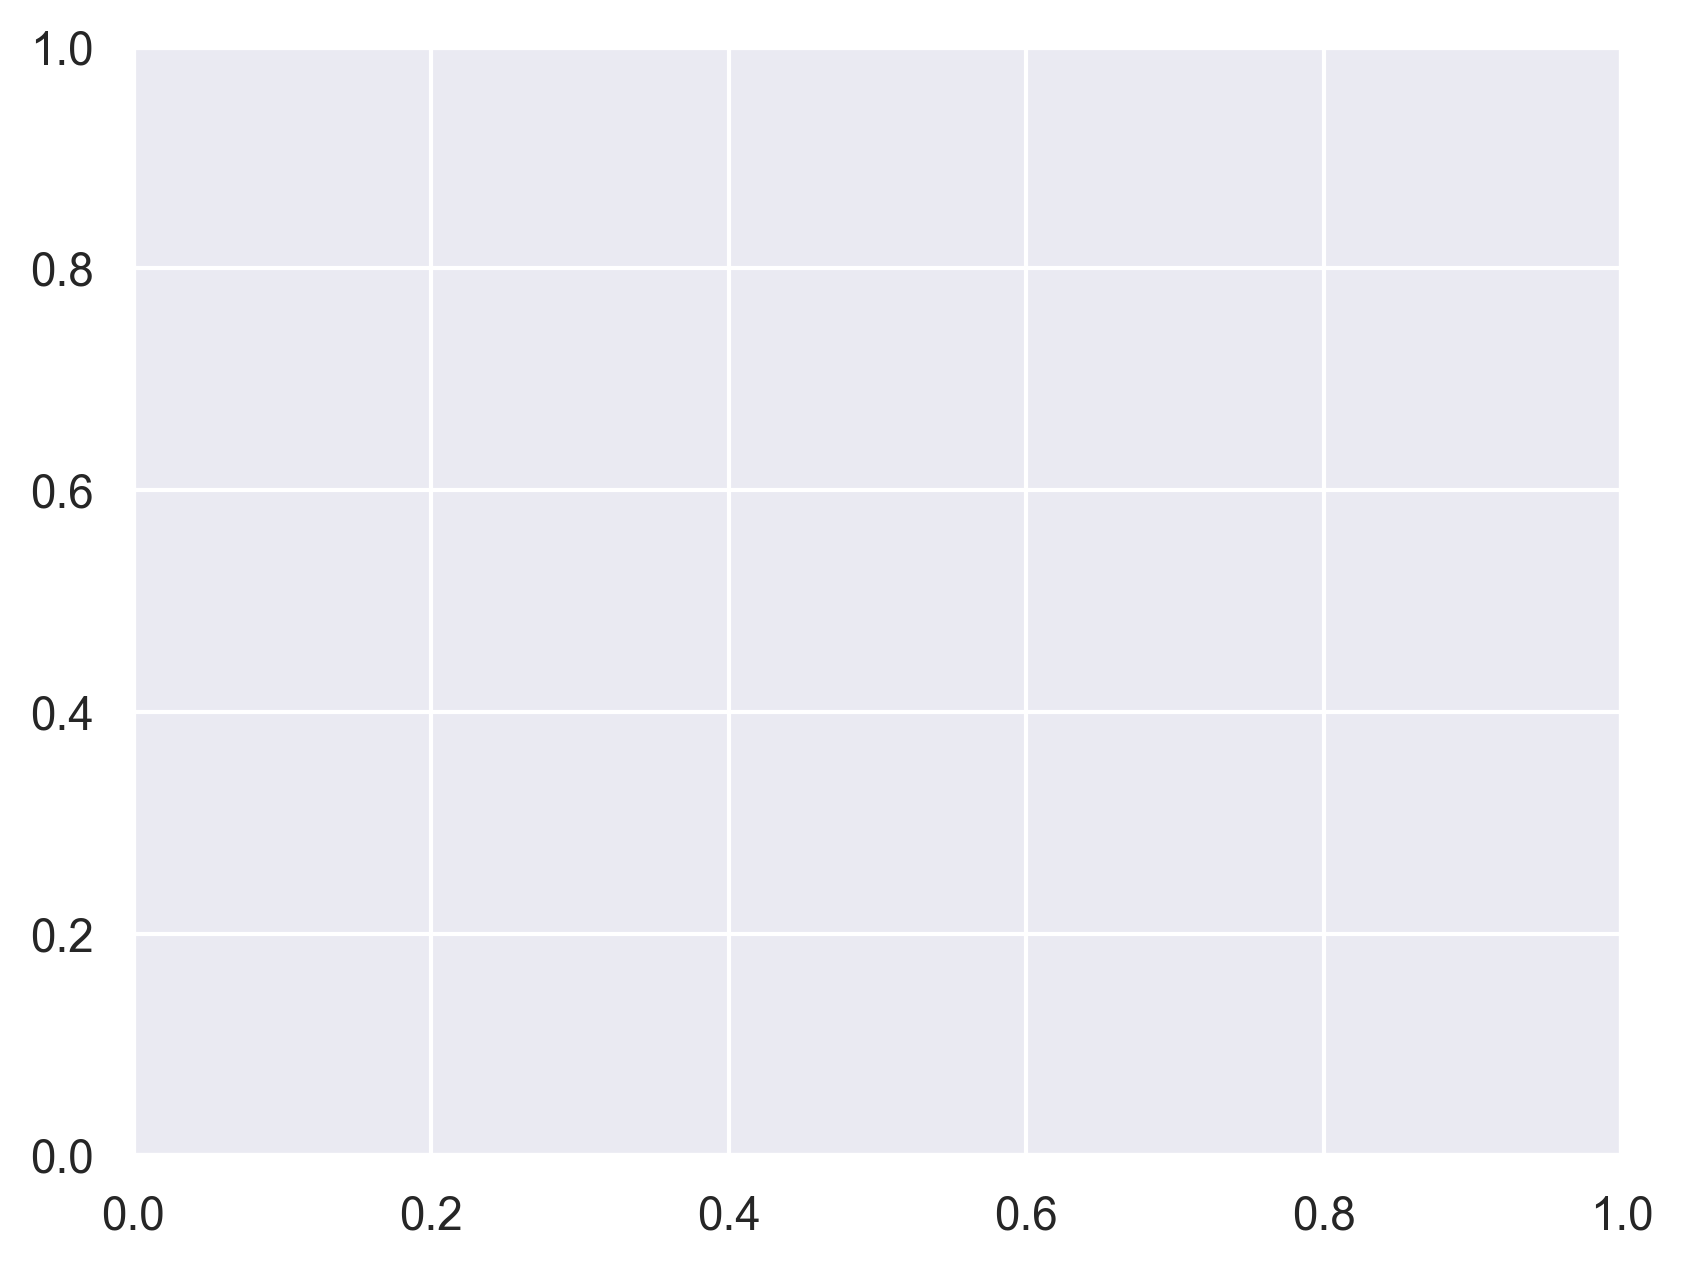

In [109]:
# 2.3

fig, ax = plt.subplots()
clf.fit(X_best1, y)

xlim = (X_best1[:, 0].min(), X_best1[:, 0].max())
ylim = (X_best1[:, 1].min(), X_best1[:, 1].max())
grid_x = np.linspace(*xlim, 100)
grid_y = np.linspace(*ylim, 100)
xx, yy = np.meshgrid(grid_x, grid_y)
grid = np.c_[xx.ravel(), yy.ravel()]
prediction = clf.predict(grid).reshape(xx.shape)
ax.contourf(xx, yy, prediction, cmap=sns.color_palette("rocket", as_cmap=True))
# ax.contourf(xx, yy, prediction)

ax = sns.scatterplot(data=pd.DataFrame(data={'1st best': X_best1[:, 0], '2nd best': X_best1[:, 1], 'target': y}),
                     x='1st best', y='2nd best', hue='target', palette="rocket", ax=ax)
# ax = sns.scatterplot(data=pd.DataFrame(data={'1st best': X_best1[:, 0], '2nd best': X_best1[:, 1], 'target': y}),
#                      x='1st best', y='2nd best', hue='target', ax=ax)
ax.set_xlim(*xlim)
ax.set_ylim(*ylim)


In [ ]:
best_model = rg

**Комментарий:** повторить для всех числовых целевых признаков. Чтобы не копировать по многу раз один и тот же код необходимо реализовать функцию нахождения двух наилучших признаков и построения тепловой карты. Предлагаю вместе с этим разобраться на следующей итерации.

In [ ]:
viz(best_model, X_best1, y)

In [ ]:
# предсказываю dimer
y = df["dimer"]

### Первая модель

In [ ]:
rg = ExtraTreesRegressor()
ypred = cross_val_predict(rg, X_pca, y, cv=LeaveOneOut())
r2_score(df["dimer"], ypred)

### Вторая модель

In [ ]:
rg = SVR()
ypred = cross_val_predict(rg, X_pca, y, cv=LeaveOneOut())
r2_score(df["dimer"], ypred)

### Третья модель

In [ ]:
rg = RidgeCV()
ypred = cross_val_predict(rg, X_pca, y, cv=LeaveOneOut())
r2_score(df["dimer"], ypred)

### Четвертая модель

In [110]:
rg = MLPRegressor((30, 40, 10), max_iter=1000, random_state=123)
ypred1 = cross_val_predict(rg, X_pca, y, cv=LeaveOneOut())
r2_score(y, ypred1)

C:\Users\ПОЛЬЗОВАТЕЛЬ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ПОЛЬЗОВАТЕЛЬ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ПОЛЬЗОВАТЕЛЬ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ПОЛЬЗОВАТЕЛЬ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterat

-16.708613219797016

### Задание 1

In [111]:
ypred1 = cross_val_predict(ExtraTreesRegressor(), X_pca, y, cv=LeaveOneOut())

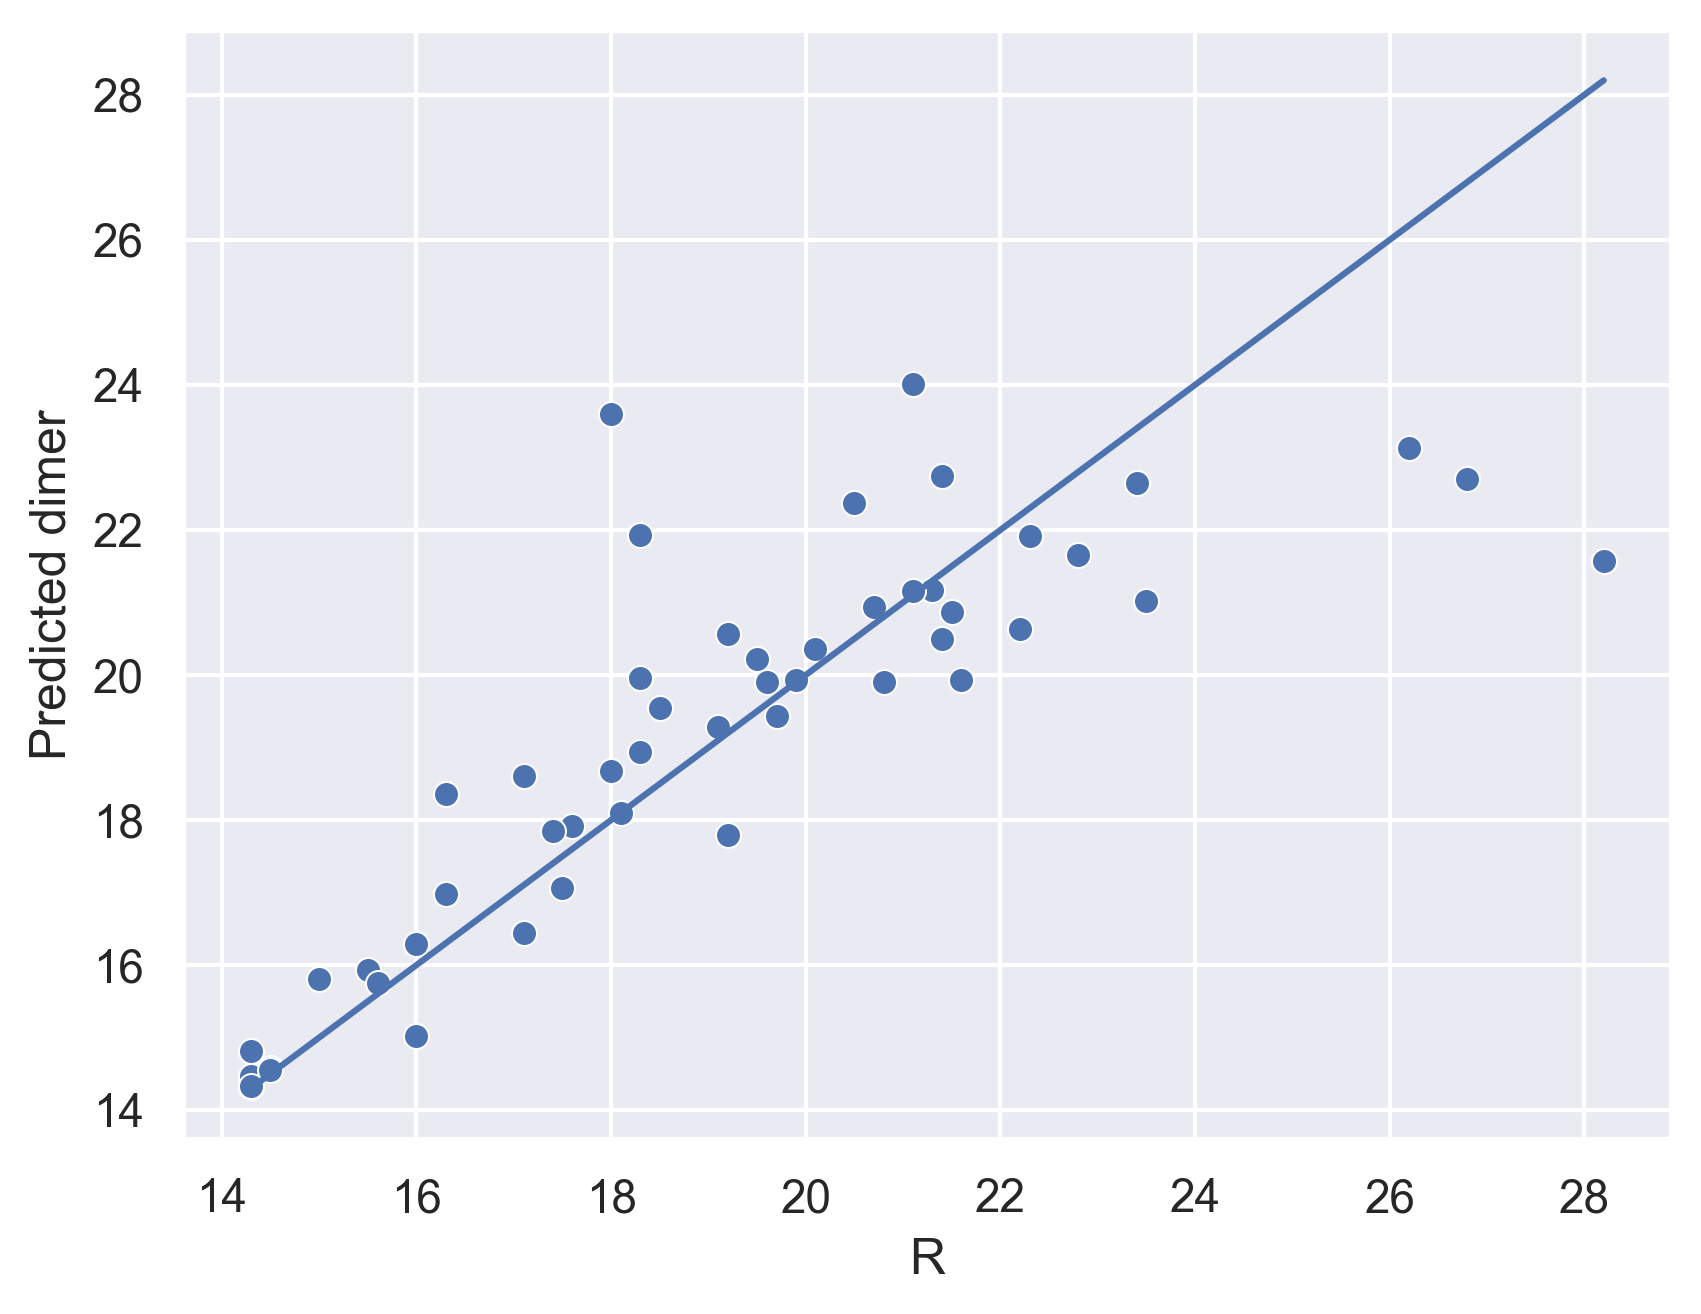

In [113]:
truePredicted(y, ypred1, "dimer")

In [112]:
#sns.scatterplot(x=y, y=ypred1)
#y_true - реальные метки
#y_pred - предсказания

### Задание 2

In [63]:
#2.1
rg = ExtraTreesRegressor()
rg.fit(X, y)
a = rg.feature_importances_
X_best1 = X[:, np.argsort(a)[::-1]][:, :2]
X_best1

array([[ 0.30138641,  0.30973469],
       [ 0.79806502,  0.58590979],
       [ 0.8413328 ,  0.61762928],
       [ 0.64746444,  0.4478983 ],
       [ 0.70864392,  0.6303547 ],
       [ 0.7369215 ,  0.61937857],
       [-0.11884385, -0.03536077],
       [ 0.66430385,  0.5018956 ],
       [ 0.74603017,  0.62882423],
       [ 0.20507955,  0.07793243],
       [ 0.34052428,  0.39436   ],
       [-1.53893954, -1.9060122 ],
       [ 0.72711167,  0.98366957],
       [ 0.54485612,  0.21733162],
       [ 0.42070059,  0.37283873],
       [-0.3534232 , -0.53679329],
       [ 0.2745317 ,  0.36603103],
       [-0.65024661, -0.37292399],
       [ 0.51136735,  0.35051287],
       [-0.49103369, -0.43909097],
       [-0.73518208, -0.4707444 ],
       [-0.5883024 , -0.44527688],
       [-0.58685256, -0.55867149],
       [-0.72502552, -0.86963968],
       [ 0.40875132,  0.49515995],
       [-0.60820393, -0.37175779],
       [ 0.3457817 ,  0.16171979],
       [ 0.69049849,  0.53836393],
       [-0.17639425,

In [64]:
#2.2.1 (ОБУЧЕНИЕ ЛИНЕЙНОЙ МОДЕЛИ НА ЛУЧШИХ ПРИЗНАКАХ)
rg = RidgeCV()
ypred = cross_val_predict(rg, X_best1, y, cv=LeaveOneOut())
r2_score(df["dimer"], ypred)

-0.14304150983954966

In [65]:
#2.2.2 (ОБУЧЕНИЕ НЕЛИНЕЙНОЙ МОДЕЛИ НА ЛУЧШИХ ПРИЗНАКАХ)
rg = MLPRegressor((30, 40, 10), max_iter=1000, random_state=123)
ypred = cross_val_predict(rg, X_best1, y, cv=LeaveOneOut())
r2_score(df["dimer"], ypred)

C:\Users\ПОЛЬЗОВАТЕЛЬ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ПОЛЬЗОВАТЕЛЬ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ПОЛЬЗОВАТЕЛЬ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ПОЛЬЗОВАТЕЛЬ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterat

0.535115846361754

In [66]:
best_model = MLPRegressor((30, 40, 10), max_iter=1000, random_state=123)

C:\Users\ПОЛЬЗОВАТЕЛЬ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


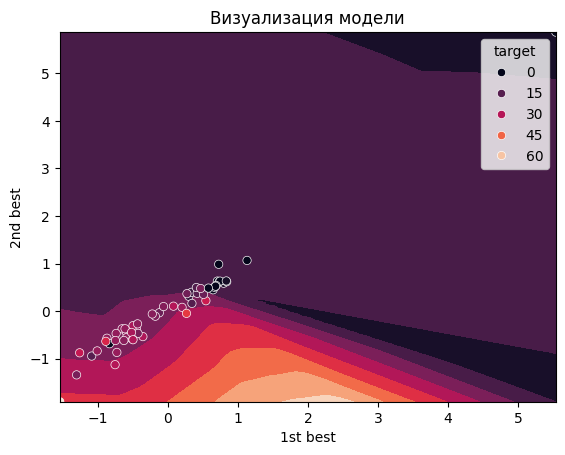

In [67]:
viz(best_model, X_best1, y)

In [68]:
# предсказываю octamer
y = df["octamer"]

### Первая модель

In [69]:
rg = ExtraTreesRegressor()
ypred = cross_val_predict(rg, X_pca, y, cv=LeaveOneOut())
r2_score(df["octamer"], ypred)

0.3292142058582751

### Вторая модель

In [70]:
rg = SVR()
ypred = cross_val_predict(rg, X_pca, y, cv=LeaveOneOut())
r2_score(df["octamer"], ypred)

0.278815732408239

### Третья модель

In [71]:
rg = RidgeCV()
ypred = cross_val_predict(rg, X_pca, y, cv=LeaveOneOut())
r2_score(df["octamer"], ypred)

-1.14301778355915

### Четвертая модель

In [72]:
rg = MLPRegressor((30, 40, 10), max_iter=1000, random_state=123)
ypred1 = cross_val_predict(rg, X_pca, y, cv=LeaveOneOut())
r2_score(y, ypred1)

C:\Users\ПОЛЬЗОВАТЕЛЬ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ПОЛЬЗОВАТЕЛЬ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ПОЛЬЗОВАТЕЛЬ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ПОЛЬЗОВАТЕЛЬ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterat

-8.685860707525675

### Задание 1

In [73]:
ypred1 = cross_val_predict(ExtraTreesRegressor(), X_pca, y, cv=LeaveOneOut())

<Axes: xlabel='octamer'>

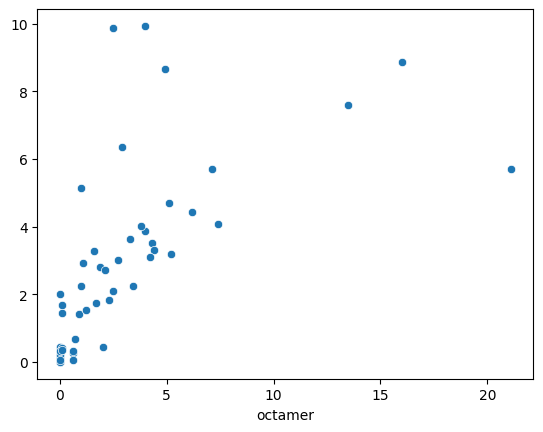

In [74]:
sns.scatterplot(x=y, y=ypred1)
#y_true - реальные метки
#y_pred - предсказания

### Задание 2

In [76]:
#2.1
rg = ExtraTreesRegressor()
rg.fit(X, y)
a = rg.feature_importances_
X_best1 = X[:, np.argsort(a)[::-1]][:, :2]
X_best1

array([[ 0.52082865,  0.39654164],
       [ 1.46685376,  1.34126668],
       [ 1.44719197,  1.35067064],
       [ 0.78389765,  0.82663213],
       [ 1.1681287 ,  1.08770326],
       [ 1.11316513,  0.98663995],
       [-0.01593387, -0.02833671],
       [ 0.67669138,  0.83877737],
       [ 1.34656286,  1.26337672],
       [ 0.65476461,  0.66530952],
       [ 1.13869264,  0.98986245],
       [-0.89104528, -0.36463558],
       [ 1.41349019,  1.47200275],
       [ 1.53567728,  1.59590426],
       [ 1.01025652,  0.91788185],
       [-0.47320828, -0.49999487],
       [ 0.59702208,  0.62881078],
       [-0.87564514, -0.82601726],
       [ 0.96730606,  1.00283552],
       [-1.00046891, -0.79403517],
       [-0.87808029, -0.88633385],
       [-0.73642945, -0.71571154],
       [-0.69109844, -0.8025185 ],
       [-1.42329584, -1.36980038],
       [ 0.82408657,  0.78588542],
       [-0.5185573 , -0.53935519],
       [ 0.20802121,  0.3105539 ],
       [ 0.84482858,  0.88001104],
       [-0.28865983,

In [77]:
#2.2.1 (ОБУЧЕНИЕ ЛИНЕЙНОЙ МОДЕЛИ НА ЛУЧШИХ ПРИЗНАКАХ)
rg = RidgeCV()
ypred = cross_val_predict(rg, X_best1, y, cv=LeaveOneOut())
r2_score(df["octamer"], ypred)

0.3541088465990333

In [78]:
#2.2.2 (ОБУЧЕНИЕ НЕЛИНЕЙНОЙ МОДЕЛИ НА ЛУЧШИХ ПРИЗНАКАХ)
rg = MLPRegressor((30, 40, 10), max_iter=1000, random_state=123)
ypred = cross_val_predict(rg, X_best1, y, cv=LeaveOneOut())
r2_score(df["octamer"], ypred)

C:\Users\ПОЛЬЗОВАТЕЛЬ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ПОЛЬЗОВАТЕЛЬ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ПОЛЬЗОВАТЕЛЬ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ПОЛЬЗОВАТЕЛЬ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterat

0.4073767728691884

In [81]:
best_model = RidgeCV()

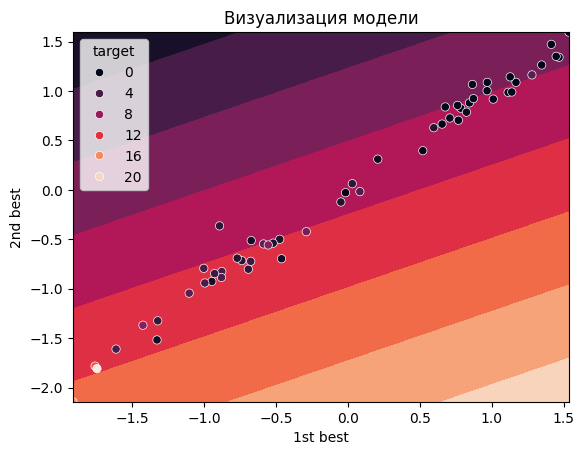

In [82]:
viz(best_model, X_best1, y)

### Идеи и предложения

Новые признаки, которые стоит попробовать:

Максимальное/минимальное/среднее/дисперсия/различные квантили значение интенсивности; \
Угол рассеивания с максимальной/минимальной интенсивностью; \
и т. д.